# 📊 Aadhaar Demographic Update Analysis
## UIDAI Hackathon 2026 - Lifecycle Stress & Behaviour Analysis

**Objective:** Analyze demographic update patterns to identify operational stress points, citizen behaviour, and migration signals.

---

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11

## 1. Data Loading & Initial Exploration

In [2]:
# Load all demographic update CSV files
data_path = Path('../data/demographic/')
csv_files = list(data_path.glob('*.csv'))

print(f"📁 Found {len(csv_files)} CSV files in demographic folder")
for f in csv_files:
    print(f"   - {f.name}")

# Concatenate all files
df_list = []
for file in csv_files:
    df_temp = pd.read_csv(file)
    df_list.append(df_temp)
    print(f"   ✅ {file.name}: {len(df_temp):,} rows")

df = pd.concat(df_list, ignore_index=True)
print(f"\n📊 Total records loaded: {len(df):,}")

📁 Found 5 CSV files in demographic folder
   - api_data_aadhar_demographic_1500000_2000000.csv
   - api_data_aadhar_demographic_500000_1000000.csv
   - api_data_aadhar_demographic_1000000_1500000.csv
   - api_data_aadhar_demographic_0_500000.csv
   - api_data_aadhar_demographic_2000000_2071700.csv


   ✅ api_data_aadhar_demographic_1500000_2000000.csv: 500,000 rows


   ✅ api_data_aadhar_demographic_500000_1000000.csv: 500,000 rows


   ✅ api_data_aadhar_demographic_1000000_1500000.csv: 500,000 rows


   ✅ api_data_aadhar_demographic_0_500000.csv: 500,000 rows
   ✅ api_data_aadhar_demographic_2000000_2071700.csv: 71,700 rows



📊 Total records loaded: 2,071,700


In [3]:
# Data info and first look
print("\n📋 Dataset Info:")
print("=" * 50)
print(df.info())
print("\n📊 Column Names:")
print(df.columns.tolist())
print("\n📊 First 5 rows:")
df.head()


📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071700 entries, 0 to 2071699
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 94.8+ MB
None

📊 Column Names:
['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']

📊 First 5 rows:


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,18-11-2025,Karnataka,Hasan,573118,0,2
1,18-11-2025,Karnataka,Hasan,573124,1,3
2,18-11-2025,Karnataka,Hasan,573150,0,2
3,18-11-2025,Karnataka,Hassan,573113,0,1
4,18-11-2025,Karnataka,Hassan,573120,1,4


In [4]:
# Rename columns for clarity
# Based on the data: demo_age_5_17 and demo_age_17_ (likely 17+)
df.columns = ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_plus']
print("✅ Columns renamed for clarity")
df.head()

✅ Columns renamed for clarity


,date,state,district,pincode,demo_age_5_17,demo_age_17_plus
0,18-11-2025,Karnataka,Hasan,573118,0,2
1,18-11-2025,Karnataka,Hasan,573124,1,3
2,18-11-2025,Karnataka,Hasan,573150,0,2
3,18-11-2025,Karnataka,Hassan,573113,0,1
4,18-11-2025,Karnataka,Hassan,573120,1,4


## 2. Data Cleaning & Transformation

In [5]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Extract time components
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['month_year'] = df['date'].dt.to_period('M').astype(str)
df['quarter'] = df['date'].dt.quarter
df['day_of_week'] = df['date'].dt.day_name()

# Calculate total demographic updates per row
df['total_demo_updates'] = df['demo_age_5_17'] + df['demo_age_17_plus']

# Standardize state names
df['state'] = df['state'].str.strip().str.title()
df['district'] = df['district'].str.strip().str.title()

print("✅ Data cleaned and transformed!")
print(f"\n📅 Date Range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"🗺️ States: {df['state'].nunique()}")
print(f"🏙️ Districts: {df['district'].nunique()}")

✅ Data cleaned and transformed!

📅 Date Range: 2025-03-01 to 2025-12-29
🗺️ States: 58


🏙️ Districts: 961


In [6]:
# Summary statistics
print("\n📈 Summary Statistics:")
df[['demo_age_5_17', 'demo_age_17_plus', 'total_demo_updates']].describe()


📈 Summary Statistics:


,demo_age_5_17,demo_age_17_plus,total_demo_updates
count,2.071700e+06,2.071700e+06,2.071700e+06
mean,2.347552e+00,2.144701e+01,2.379456e+01
std,1.490355e+01,1.252498e+02,1.381999e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.000000e+00,3.000000e+00
50%,1.000000e+00,6.000000e+00,7.000000e+00
75%,2.000000e+00,1.500000e+01,1.700000e+01
max,2.690000e+03,1.616600e+04,1.694200e+04


## 3. Univariate Analysis

### 3.1 Temporal Trends

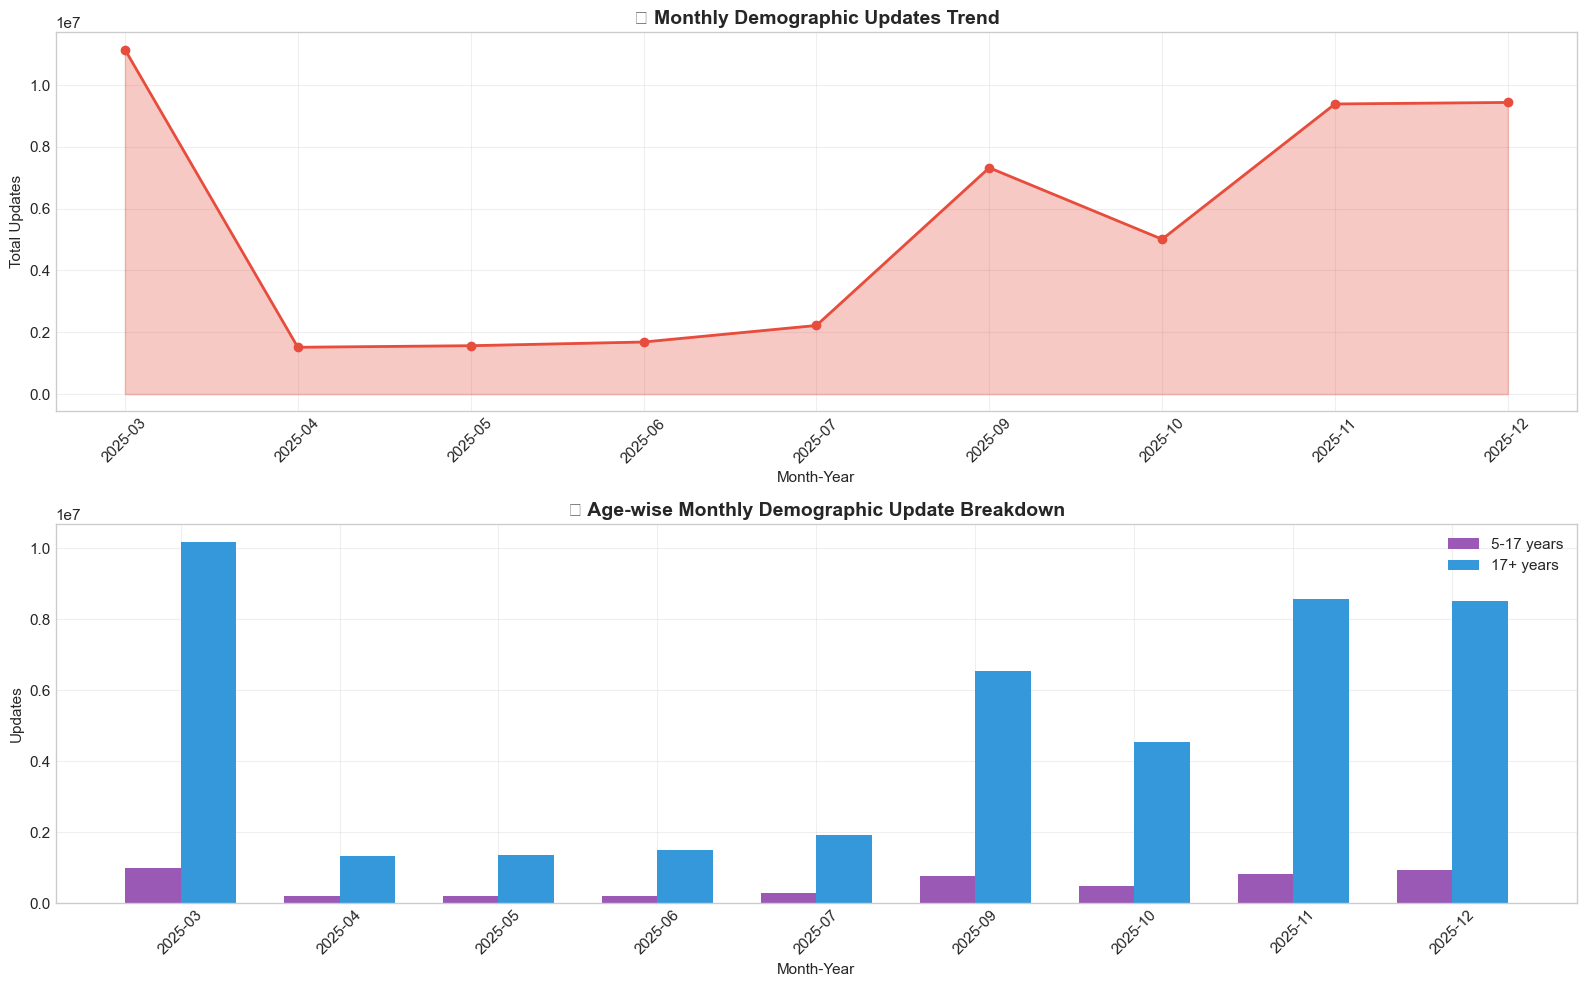

In [7]:
# Monthly demographic update trend
monthly_trend = df.groupby('month_year').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_plus': 'sum',
    'total_demo_updates': 'sum'
}).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Total update trend
axes[0].plot(monthly_trend['month_year'], monthly_trend['total_demo_updates'], 
             marker='o', linewidth=2, markersize=6, color='#E74C3C')
axes[0].fill_between(range(len(monthly_trend)), monthly_trend['total_demo_updates'], alpha=0.3, color='#E74C3C')
axes[0].set_title('📈 Monthly Demographic Updates Trend', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month-Year')
axes[0].set_ylabel('Total Updates')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Age group breakdown
x = range(len(monthly_trend))
width = 0.35
axes[1].bar([i-width/2 for i in x], monthly_trend['demo_age_5_17'], width, label='5-17 years', color='#9B59B6')
axes[1].bar([i+width/2 for i in x], monthly_trend['demo_age_17_plus'], width, label='17+ years', color='#3498DB')
axes[1].set_title('📊 Age-wise Monthly Demographic Update Breakdown', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month-Year')
axes[1].set_ylabel('Updates')
axes[1].set_xticks(x)
axes[1].set_xticklabels(monthly_trend['month_year'], rotation=45)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/charts/demographic_monthly_trend.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Age Group Distribution

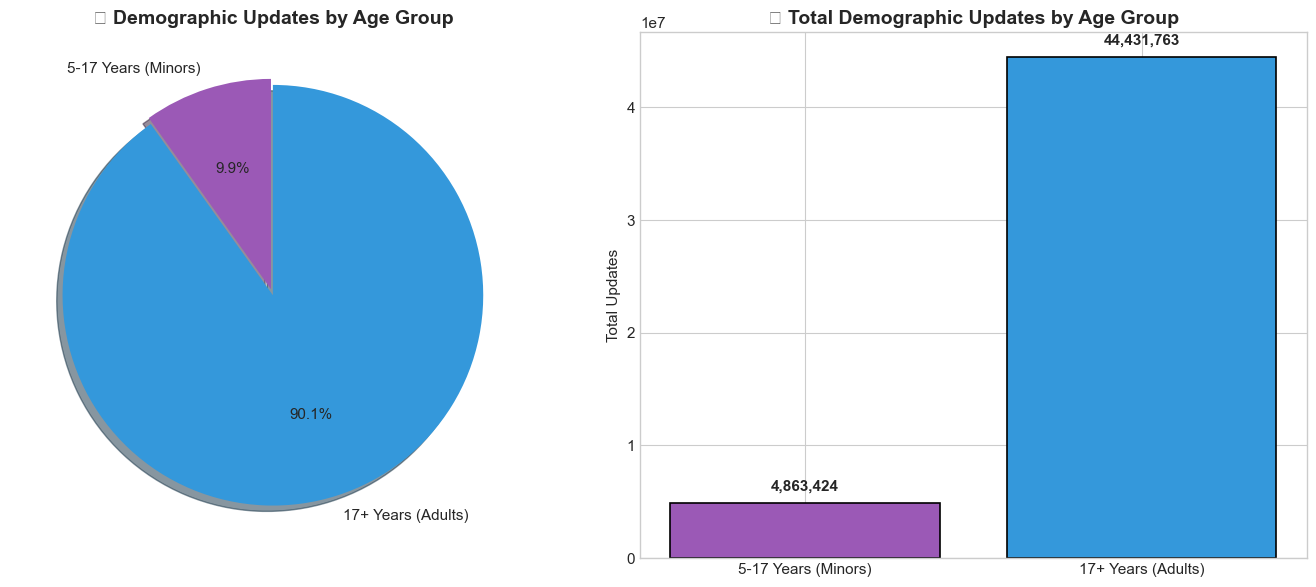


📋 Age Group Summary:
  5-17 Years (Minors): 4,863,424 (9.9%)
  17+ Years (Adults): 44,431,763 (90.1%)

💡 INSIGHT: Adult demographic updates dominate (90.1%)
   Possible reasons: Address changes (migration), mobile updates, corrections


In [8]:
# Age group distribution for updates
age_totals = {
    '5-17 Years (Minors)': df['demo_age_5_17'].sum(),
    '17+ Years (Adults)': df['demo_age_17_plus'].sum()
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
colors = ['#9B59B6', '#3498DB']
explode = (0.03, 0)
axes[0].pie(age_totals.values(), labels=age_totals.keys(), autopct='%1.1f%%',
           colors=colors, explode=explode, shadow=True, startangle=90)
axes[0].set_title('🎯 Demographic Updates by Age Group', fontsize=14, fontweight='bold')

# Bar chart with values
bars = axes[1].bar(age_totals.keys(), age_totals.values(), color=colors, edgecolor='black', linewidth=1.2)
axes[1].set_title('📊 Total Demographic Updates by Age Group', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Updates')
for bar, value in zip(bars, age_totals.values()):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02*max(age_totals.values()),
                f'{value:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/charts/demographic_age_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
total = sum(age_totals.values())
print("\n📋 Age Group Summary:")
print("=" * 50)
for group, count in age_totals.items():
    print(f"  {group}: {count:,.0f} ({count/total*100:.1f}%)")

print(f"\n💡 INSIGHT: Adult demographic updates dominate ({age_totals['17+ Years (Adults)']/total*100:.1f}%)")
print("   Possible reasons: Address changes (migration), mobile updates, corrections")

## 4. Bivariate Analysis

### 4.1 State-wise Demographic Update Analysis

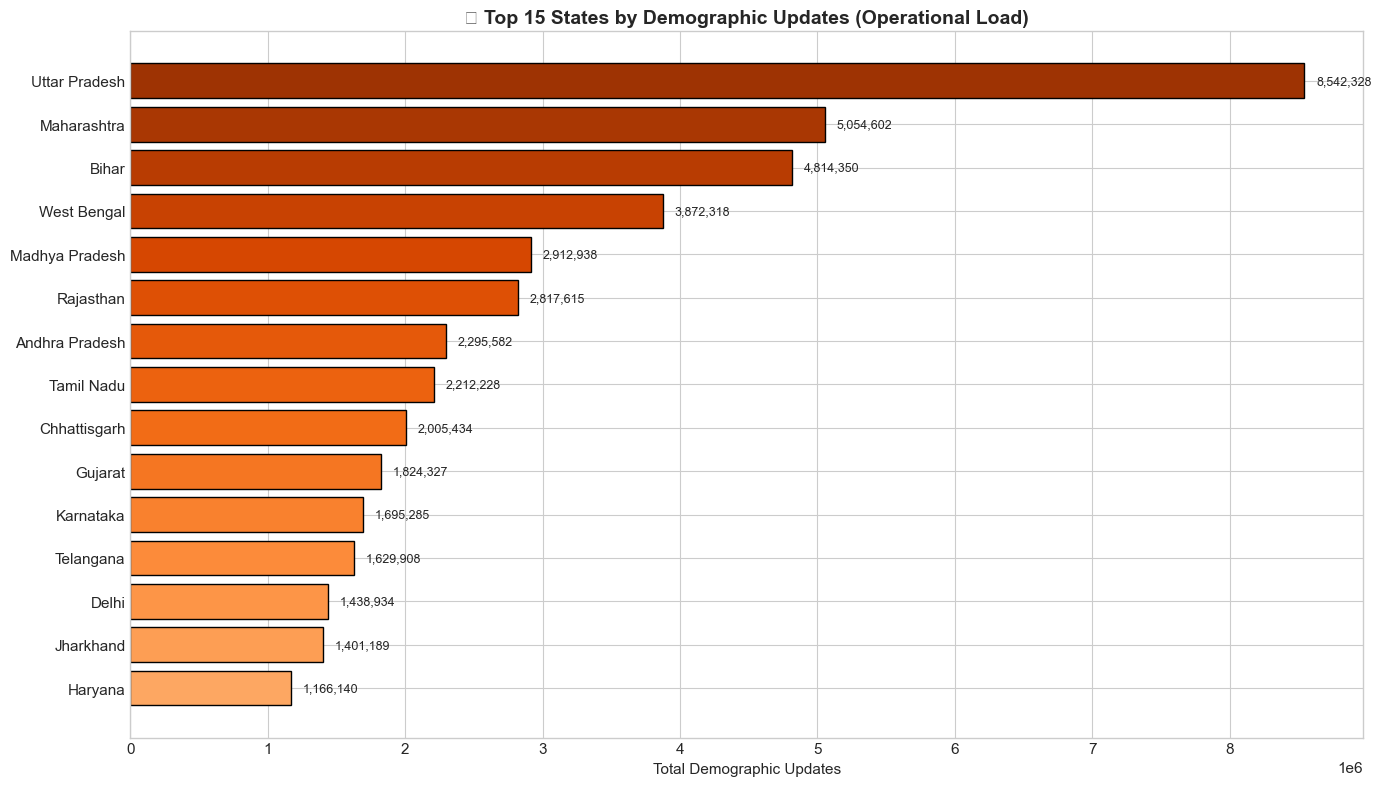


💡 INSIGHT: High update states indicate:
   - Major migration destinations (employment hubs)
   - High mobile penetration/update awareness
   - Urban population concentration


In [9]:
# State-wise total updates
state_updates = df.groupby('state').agg({
    'demo_age_5_17': 'sum',
    'demo_age_17_plus': 'sum',
    'total_demo_updates': 'sum'
}).reset_index().sort_values('total_demo_updates', ascending=False)

# Top 15 states
top_states = state_updates.head(15)

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.Oranges(np.linspace(0.4, 0.9, len(top_states)))[::-1]

bars = ax.barh(top_states['state'], top_states['total_demo_updates'], color=colors, edgecolor='black')
ax.set_xlabel('Total Demographic Updates')
ax.set_title('🏆 Top 15 States by Demographic Updates (Operational Load)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add value labels
for bar, value in zip(bars, top_states['total_demo_updates']):
    ax.text(value + 0.01*max(top_states['total_demo_updates']), bar.get_y() + bar.get_height()/2,
           f'{value:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/charts/demographic_top_states.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INSIGHT: High update states indicate:")
print("   - Major migration destinations (employment hubs)")
print("   - High mobile penetration/update awareness")
print("   - Urban population concentration")

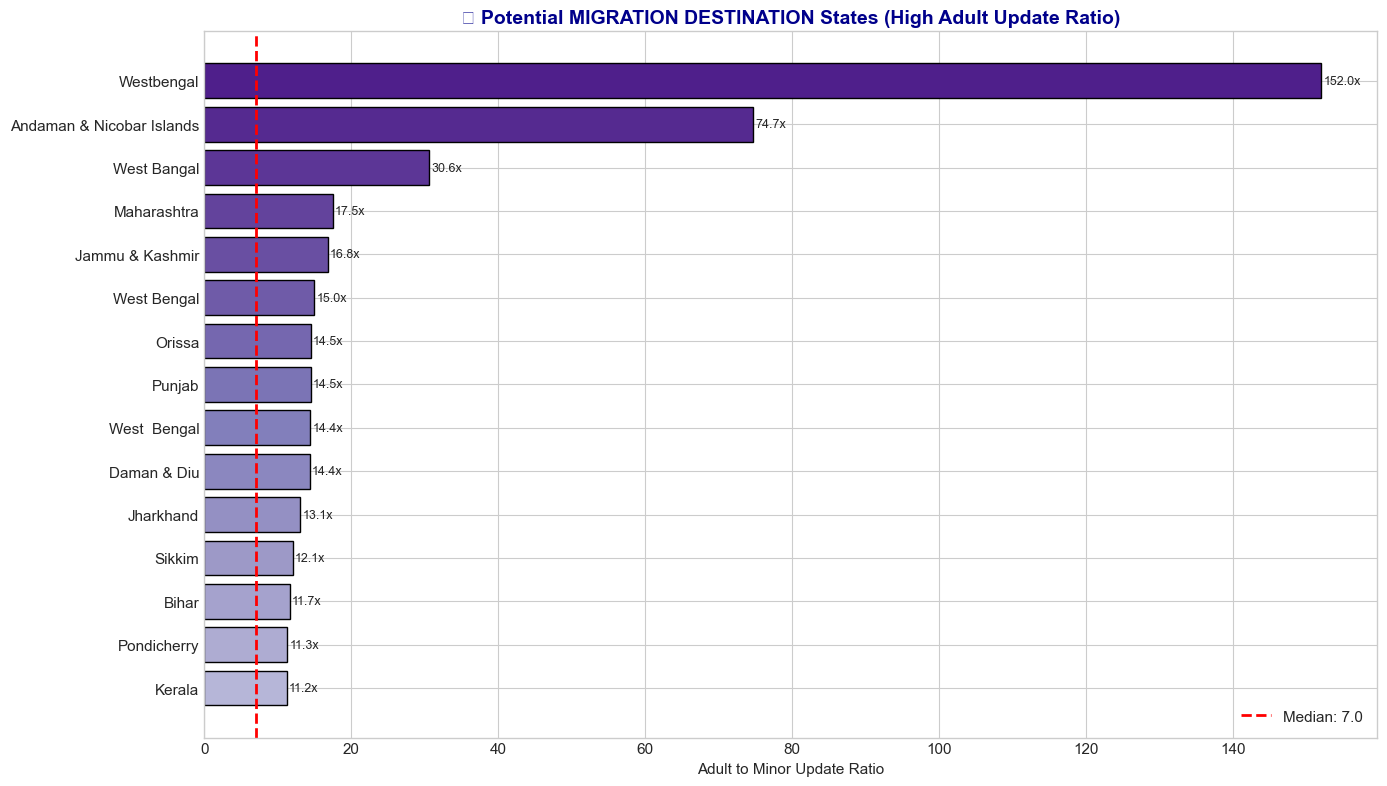


🚀 MIGRATION INSIGHT:
   States with high adult update ratios likely receive working-age migrants
   These updates are primarily address/mobile changes post-migration


In [10]:
# Calculate adult-to-minor update ratio (higher = more adult updates = migration signal)
state_updates['adult_minor_ratio'] = state_updates['demo_age_17_plus'] / (state_updates['demo_age_5_17'] + 1)

# States with highest adult/minor ratio (migration destinations)
migration_states = state_updates.nlargest(15, 'adult_minor_ratio')

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.Purples(np.linspace(0.4, 0.9, len(migration_states)))[::-1]

bars = ax.barh(migration_states['state'], migration_states['adult_minor_ratio'], color=colors, edgecolor='black')
ax.set_xlabel('Adult to Minor Update Ratio')
ax.set_title('🚀 Potential MIGRATION DESTINATION States (High Adult Update Ratio)', 
            fontsize=14, fontweight='bold', color='darkblue')
ax.invert_yaxis()
ax.axvline(x=state_updates['adult_minor_ratio'].median(), color='red', linestyle='--', 
          linewidth=2, label=f"Median: {state_updates['adult_minor_ratio'].median():.1f}")
ax.legend()

for bar, value in zip(bars, migration_states['adult_minor_ratio']):
    ax.text(value + 0.3, bar.get_y() + bar.get_height()/2, f'{value:.1f}x', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/charts/demographic_migration_signal.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🚀 MIGRATION INSIGHT:")
print("   States with high adult update ratios likely receive working-age migrants")
print("   These updates are primarily address/mobile changes post-migration")

### 4.2 Update Frequency - High Stress Regions

In [11]:
# District-wise analysis for operational stress
district_updates = df.groupby(['state', 'district']).agg({
    'total_demo_updates': 'sum',
    'demo_age_17_plus': 'sum',
    'date': 'nunique'  # Number of active days
}).reset_index()
district_updates.columns = ['state', 'district', 'total_updates', 'adult_updates', 'active_days']

# Calculate daily average updates (operational intensity)
district_updates['daily_avg'] = district_updates['total_updates'] / district_updates['active_days']

# Top 20 high-intensity districts
high_stress_districts = district_updates.nlargest(20, 'total_updates')

print("\n🔥 TOP 20 HIGH-STRESS DISTRICTS (Demographic Updates):")
print("=" * 80)
for _, row in high_stress_districts.iterrows():
    print(f"  {row['district']}, {row['state']}: {row['total_updates']:,.0f} updates | Avg: {row['daily_avg']:.0f}/day")


🔥 TOP 20 HIGH-STRESS DISTRICTS (Demographic Updates):
  Thane, Maharashtra: 447,253 updates | Avg: 4708/day
  Pune, Maharashtra: 438,478 updates | Avg: 4616/day
  South 24 Parganas, West Bengal: 401,187 updates | Avg: 4223/day
  Murshidabad, West Bengal: 371,953 updates | Avg: 3915/day
  Surat, Gujarat: 357,582 updates | Avg: 3764/day
  North West Delhi, Delhi: 313,989 updates | Avg: 3305/day
  Bengaluru, Karnataka: 303,924 updates | Avg: 3199/day
  North 24 Parganas, West Bengal: 290,477 updates | Avg: 3123/day
  Jaipur, Rajasthan: 275,340 updates | Avg: 2898/day
  Uttar Dinajpur, West Bengal: 270,232 updates | Avg: 2845/day
  Ahmedabad, Gujarat: 267,884 updates | Avg: 2820/day
  Solapur, Maharashtra: 265,546 updates | Avg: 2886/day
  East Champaran, Bihar: 248,028 updates | Avg: 2726/day
  Nashik, Maharashtra: 246,100 updates | Avg: 2618/day
  Patna, Bihar: 243,772 updates | Avg: 2679/day
  Bareilly, Uttar Pradesh: 241,742 updates | Avg: 2545/day
  Ghaziabad, Uttar Pradesh: 239,761 

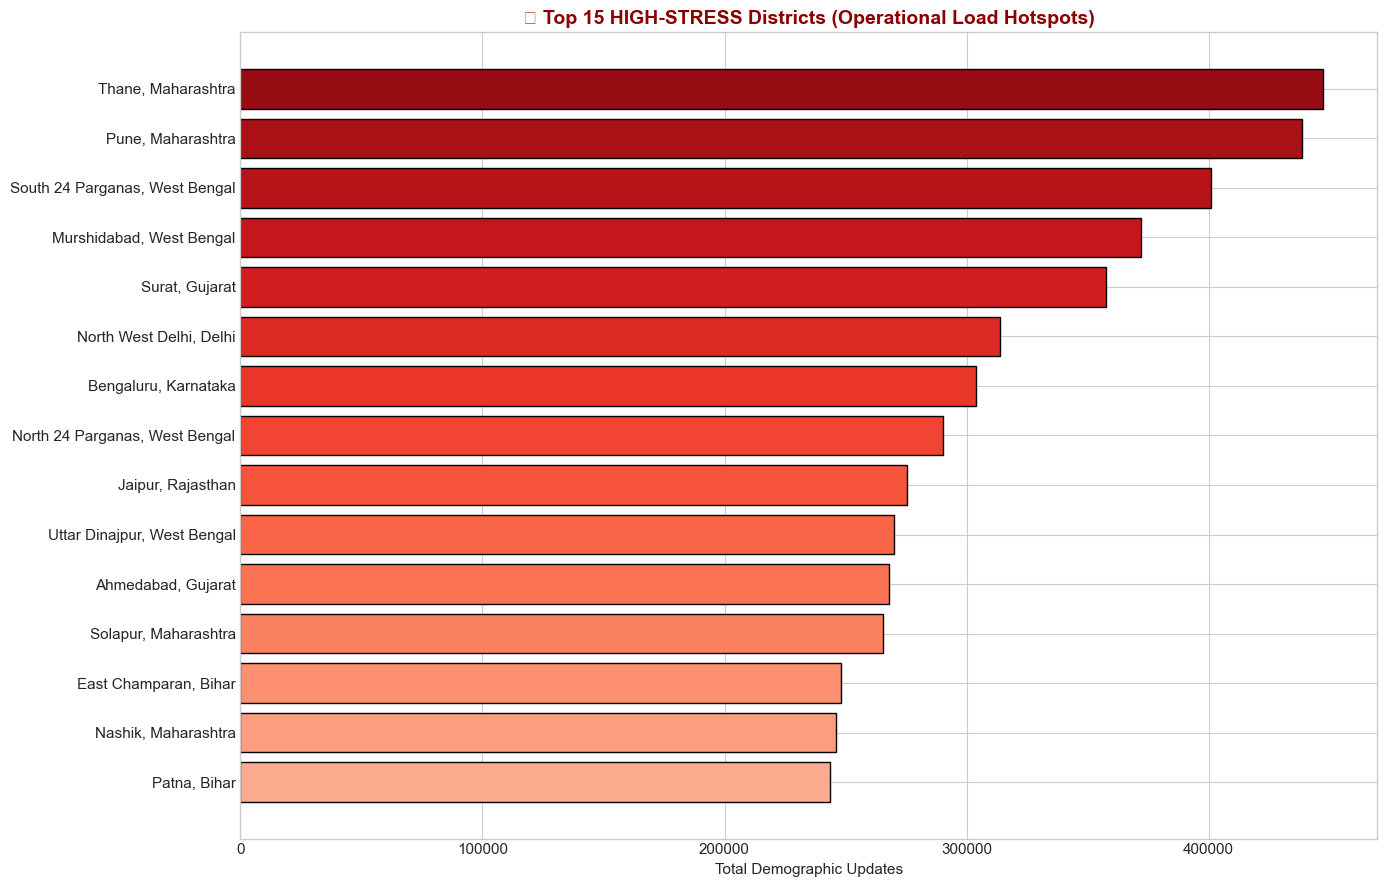


🎯 POLICY RECOMMENDATION:
   These districts need enhanced infrastructure and staffing!


In [12]:
# Visualize top districts
top_districts = high_stress_districts.head(15)
top_districts['label'] = top_districts['district'] + ', ' + top_districts['state']

fig, ax = plt.subplots(figsize=(14, 9))
colors = plt.cm.Reds(np.linspace(0.3, 0.9, len(top_districts)))[::-1]

bars = ax.barh(top_districts['label'], top_districts['total_updates'], color=colors, edgecolor='black')
ax.set_xlabel('Total Demographic Updates')
ax.set_title('🔥 Top 15 HIGH-STRESS Districts (Operational Load Hotspots)', fontsize=14, fontweight='bold', color='darkred')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../outputs/charts/demographic_stress_districts.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n🎯 POLICY RECOMMENDATION:")
print("   These districts need enhanced infrastructure and staffing!")

## 5. Day-of-Week Analysis (Citizen Behaviour)

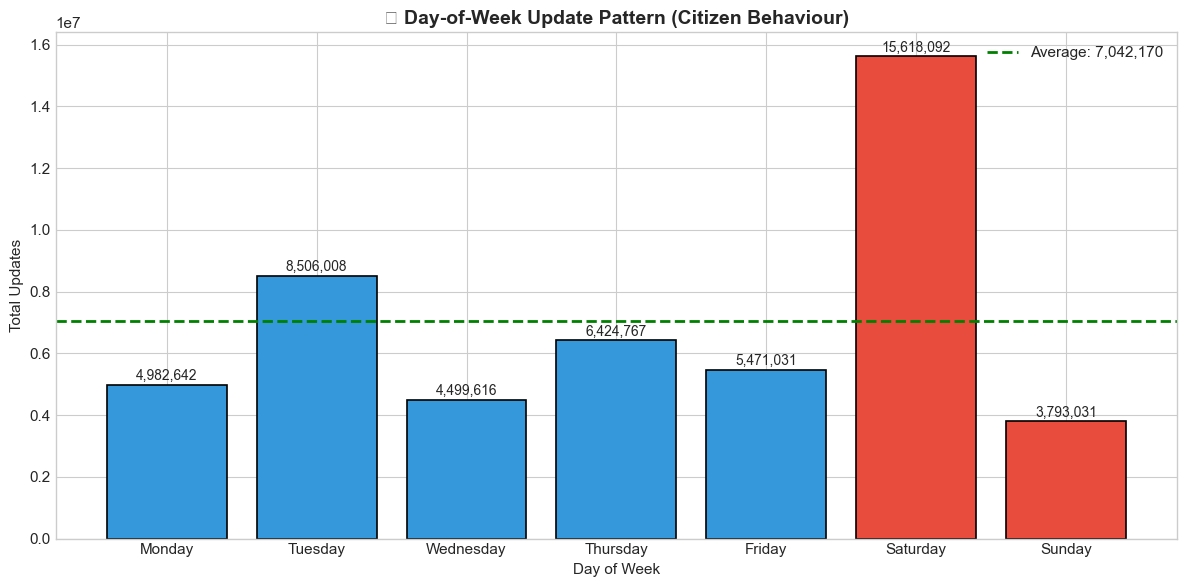


📊 Peak Update Day: Saturday (15,618,092 updates)

💡 INSIGHT: This pattern informs optimal staffing schedules


In [13]:
# Day-wise update patterns
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_updates = df.groupby('day_of_week')['total_demo_updates'].sum().reindex(day_order)

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#3498DB' if day not in ['Saturday', 'Sunday'] else '#E74C3C' for day in day_order]

bars = ax.bar(day_updates.index, day_updates.values, color=colors, edgecolor='black', linewidth=1.2)
ax.set_title('📅 Day-of-Week Update Pattern (Citizen Behaviour)', fontsize=14, fontweight='bold')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Total Updates')

# Add value labels
for bar, value in zip(bars, day_updates.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(day_updates.values),
           f'{value:,.0f}', ha='center', fontsize=10)

ax.axhline(y=day_updates.mean(), color='green', linestyle='--', linewidth=2, label=f'Average: {day_updates.mean():,.0f}')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/charts/demographic_dayofweek.png', dpi=150, bbox_inches='tight')
plt.show()

peak_day = day_updates.idxmax()
print(f"\n📊 Peak Update Day: {peak_day} ({day_updates.max():,.0f} updates)")
print("\n💡 INSIGHT: This pattern informs optimal staffing schedules")

## 6. Trivariate Analysis: State × Age × Time

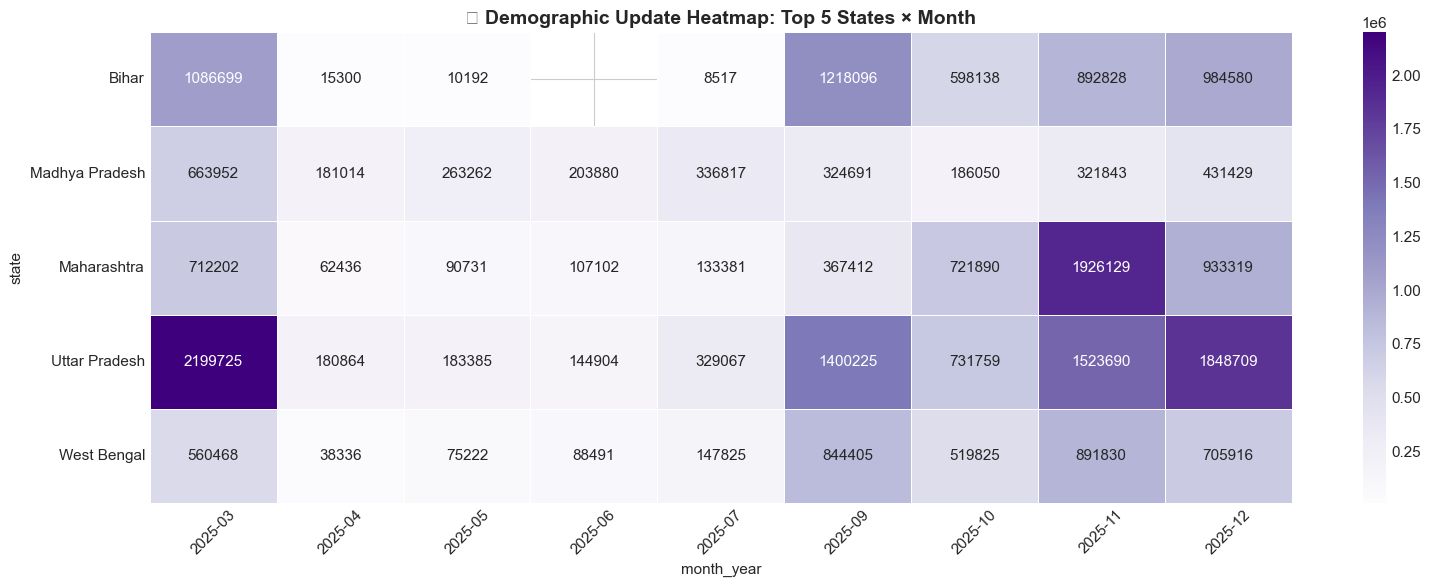

In [14]:
# Heatmap: State vs Month for Top States
top_5_states = state_updates.head(5)['state'].tolist()
df_top = df[df['state'].isin(top_5_states)]

pivot = df_top.pivot_table(
    values='total_demo_updates', 
    index='state', 
    columns='month_year', 
    aggfunc='sum'
)

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot, cmap='Purples', annot=True, fmt='.0f', linewidths=0.5, ax=ax)
ax.set_title('🔥 Demographic Update Heatmap: Top 5 States × Month', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../outputs/charts/demographic_heatmap_state_time.png', dpi=150, bbox_inches='tight')
plt.show()

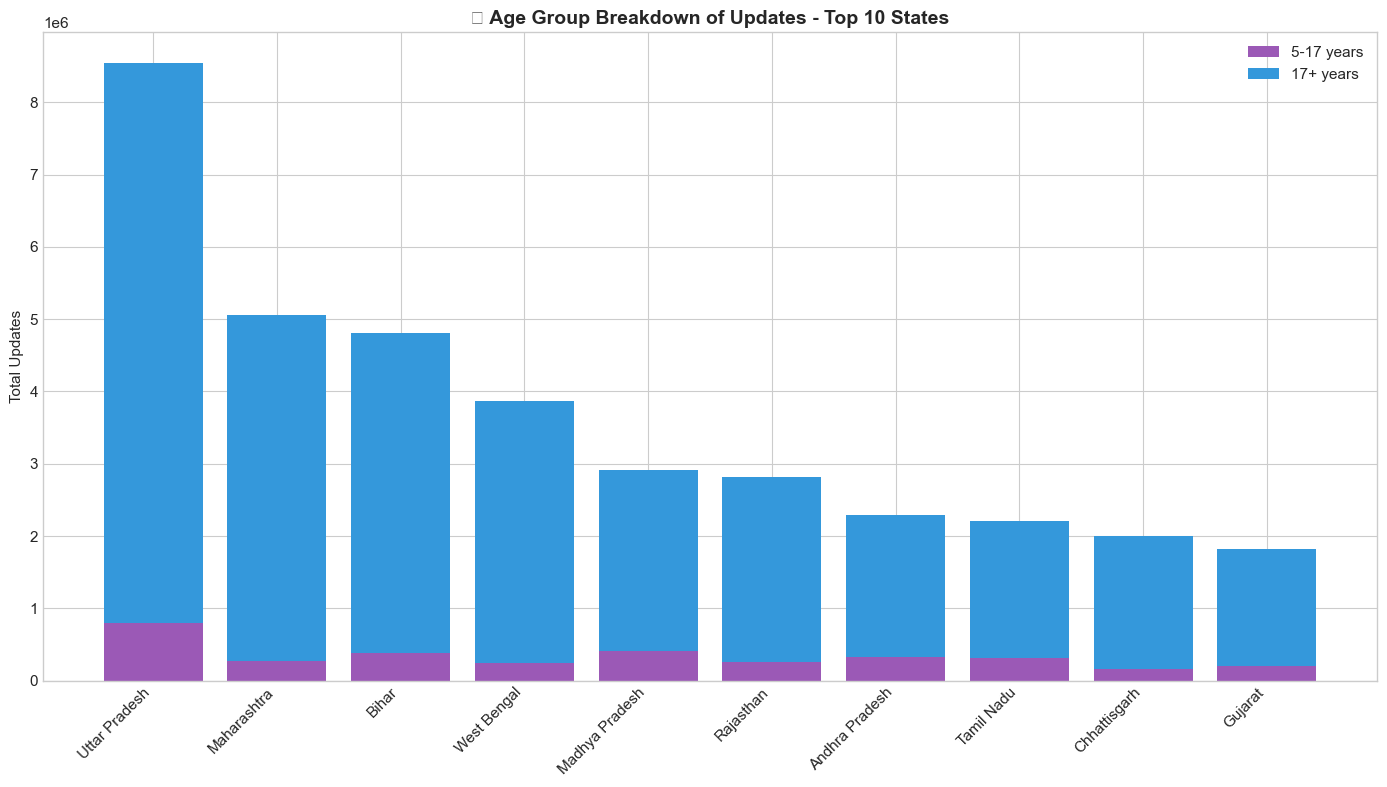

In [15]:
# Age group comparison across top states (stacked bar)
top_10_states = state_updates.head(10)

fig, ax = plt.subplots(figsize=(14, 8))

x = range(len(top_10_states))
ax.bar(x, top_10_states['demo_age_5_17'], label='5-17 years', color='#9B59B6')
ax.bar(x, top_10_states['demo_age_17_plus'], bottom=top_10_states['demo_age_5_17'], 
      label='17+ years', color='#3498DB')

ax.set_xticks(x)
ax.set_xticklabels(top_10_states['state'], rotation=45, ha='right')
ax.set_ylabel('Total Updates')
ax.set_title('📊 Age Group Breakdown of Updates - Top 10 States', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/charts/demographic_age_by_state.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Update Intensity Score (Composite Metric)

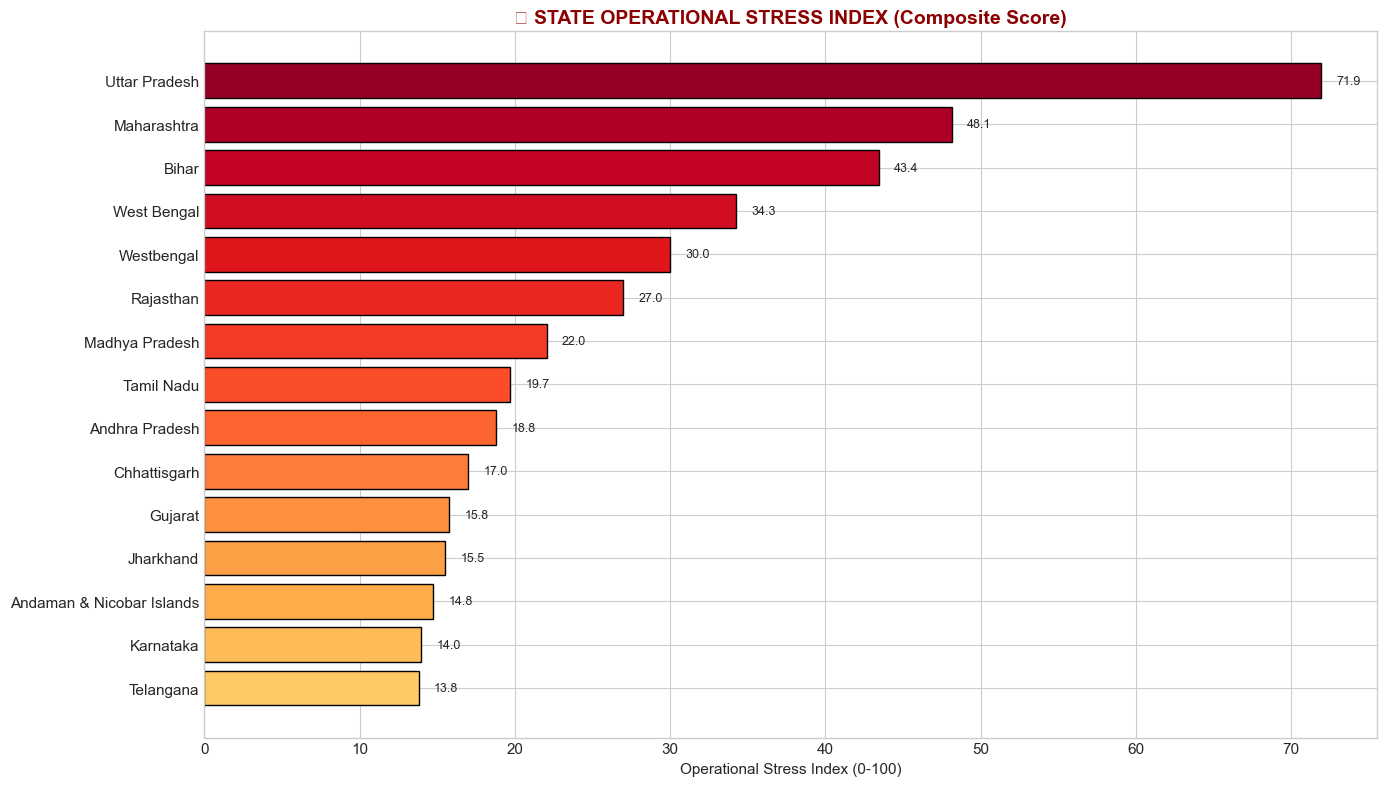


📊 STRESS INDEX COMPONENTS:
   - Volume Score (50%): Total demographic updates
   - Migration Score (30%): Adult-to-minor update ratio
   - Volatility Score (20%): Month-to-month variation


In [16]:
# Create an Update Intensity Index for states
# Factors: Total updates, Adult ratio, Consistency

state_monthly = df.groupby(['state', 'month_year'])['total_demo_updates'].sum().reset_index()
state_consistency = state_monthly.groupby('state')['total_demo_updates'].std().reset_index()
state_consistency.columns = ['state', 'update_volatility']

# Merge metrics
state_metrics = state_updates.merge(state_consistency, on='state')

# Normalize metrics (0-100 scale)
state_metrics['volume_score'] = (state_metrics['total_demo_updates'] / state_metrics['total_demo_updates'].max()) * 100
state_metrics['migration_score'] = (state_metrics['adult_minor_ratio'] / state_metrics['adult_minor_ratio'].max()) * 100
state_metrics['volatility_score'] = (state_metrics['update_volatility'] / state_metrics['update_volatility'].max()) * 100

# Composite Stress Index (higher = more operational stress)
state_metrics['stress_index'] = (state_metrics['volume_score'] * 0.5 + 
                                  state_metrics['migration_score'] * 0.3 + 
                                  state_metrics['volatility_score'] * 0.2)

# Top 15 stressed states
high_stress = state_metrics.nlargest(15, 'stress_index')

fig, ax = plt.subplots(figsize=(14, 8))
colors = plt.cm.YlOrRd(np.linspace(0.3, 0.95, len(high_stress)))[::-1]

bars = ax.barh(high_stress['state'], high_stress['stress_index'], color=colors, edgecolor='black')
ax.set_xlabel('Operational Stress Index (0-100)')
ax.set_title('🚨 STATE OPERATIONAL STRESS INDEX (Composite Score)', fontsize=14, fontweight='bold', color='darkred')
ax.invert_yaxis()

for bar, value in zip(bars, high_stress['stress_index']):
    ax.text(value + 1, bar.get_y() + bar.get_height()/2, f'{value:.1f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/charts/demographic_stress_index.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 STRESS INDEX COMPONENTS:")
print("   - Volume Score (50%): Total demographic updates")
print("   - Migration Score (30%): Adult-to-minor update ratio")
print("   - Volatility Score (20%): Month-to-month variation")

## 8. Summary Table Generation

In [17]:
# Create comprehensive state summary
state_summary = df.groupby('state').agg({
    'total_demo_updates': 'sum',
    'demo_age_5_17': 'sum',
    'demo_age_17_plus': 'sum',
    'district': 'nunique',
    'pincode': 'nunique'
}).reset_index()

state_summary.columns = ['State', 'Total_Updates', 'Updates_Age_5_17', 'Updates_Age_17_Plus', 'Districts', 'Pincodes']
state_summary['Minor_Ratio_%'] = (state_summary['Updates_Age_5_17'] / state_summary['Total_Updates'] * 100).round(1)
state_summary['Adult_Ratio_%'] = (state_summary['Updates_Age_17_Plus'] / state_summary['Total_Updates'] * 100).round(1)
state_summary['Adult_Minor_Ratio'] = (state_summary['Updates_Age_17_Plus'] / (state_summary['Updates_Age_5_17'] + 1)).round(1)
state_summary = state_summary.sort_values('Total_Updates', ascending=False)

# Save to CSV
state_summary.to_csv('../outputs/summary_tables/demographic_state_summary.csv', index=False)
print("✅ State summary saved to outputs/summary_tables/demographic_state_summary.csv")

# Display top states
print("\n📊 STATE-WISE DEMOGRAPHIC UPDATE SUMMARY (Top 15):")
state_summary.head(15)

✅ State summary saved to outputs/summary_tables/demographic_state_summary.csv

📊 STATE-WISE DEMOGRAPHIC UPDATE SUMMARY (Top 15):


,State,Total_Updates,Updates_Age_5_17,Updates_Age_17_Plus,Districts,Pincodes,Minor_Ratio_%,Adult_Ratio_%,Adult_Minor_Ratio
50,Uttar Pradesh,8542328,790308,7752020,90,1760,9.3,90.7,9.8
32,Maharashtra,5054602,273322,4781280,53,1609,5.4,94.6,17.5
7,Bihar,4814350,380023,4434327,46,921,7.9,92.1,11.7
55,West Bengal,3872318,242551,3629767,48,1364,6.3,93.7,15.0
31,Madhya Pradesh,2912938,407098,2505840,60,796,14.0,86.0,6.2
45,Rajasthan,2817615,257224,2560391,45,989,9.1,90.9,10.0
3,Andhra Pradesh,2295582,321148,1974434,45,1846,14.0,86.0,6.1
47,Tamil Nadu,2212228,315638,1896590,45,2089,14.3,85.7,6.0
10,Chhattisgarh,2005434,165207,1840227,39,268,8.2,91.8,11.1
19,Gujarat,1824327,208474,1615853,39,1030,11.4,88.6,7.8


## 9. Key Findings & Policy Insights

In [18]:
# Generate key insights
print("\n" + "="*70)
print("📋 KEY FINDINGS - AADHAAR DEMOGRAPHIC UPDATE ANALYSIS")
print("="*70)

total_updates = df['total_demo_updates'].sum()
minor_updates = df['demo_age_5_17'].sum()
adult_updates = df['demo_age_17_plus'].sum()

print(f"\n✅ TOTAL DEMOGRAPHIC UPDATES: {total_updates:,.0f}")
print(f"   - Minors (5-17): {minor_updates:,.0f} ({minor_updates/total_updates*100:.1f}%)")
print(f"   - Adults (17+): {adult_updates:,.0f} ({adult_updates/total_updates*100:.1f}%)")

print(f"\n📍 GEOGRAPHIC COVERAGE:")
print(f"   - States/UTs: {df['state'].nunique()}")
print(f"   - Districts: {df['district'].nunique()}")
print(f"   - Pincodes: {df['pincode'].nunique()}")

# Top performing states
top_3 = state_summary.head(3)['State'].tolist()
print(f"\n🏆 HIGHEST UPDATE VOLUME STATES: {', '.join(top_3)}")

# Migration destination states
migration_destinations = state_metrics.nlargest(5, 'migration_score')['state'].tolist()
print(f"\n🚀 MIGRATION DESTINATION SIGNALS: {', '.join(migration_destinations)}")

print("\n" + "="*70)
print("📌 POLICY RECOMMENDATIONS:")
print("="*70)
print("""
1. OPERATIONAL SCALING:
   - High-stress states need additional enrolment centers
   - Deploy mobile units in high-density urban areas
   - Extended hours during peak days

2. MIGRATION CORRIDOR FOCUS:
   - Establish interstate data sync protocols
   - Partner with employment hubs for address updates
   - Special camps at construction sites, industrial areas

3. DIGITAL ENABLEMENT:
   - Promote self-service demographic updates
   - Mobile app awareness campaigns
   - Reduce physical center dependency for simple updates

4. MINOR UPDATE FOCUS:
   - School-based update drives for 5-17 age group
   - Address correction campaigns post-admission
""")


📋 KEY FINDINGS - AADHAAR DEMOGRAPHIC UPDATE ANALYSIS

✅ TOTAL DEMOGRAPHIC UPDATES: 49,295,187
   - Minors (5-17): 4,863,424 (9.9%)
   - Adults (17+): 44,431,763 (90.1%)

📍 GEOGRAPHIC COVERAGE:


   - States/UTs: 58
   - Districts: 961


   - Pincodes: 19742

🏆 HIGHEST UPDATE VOLUME STATES: Uttar Pradesh, Maharashtra, Bihar

🚀 MIGRATION DESTINATION SIGNALS: Westbengal, Andaman & Nicobar Islands, West Bangal, Maharashtra, Jammu & Kashmir

📌 POLICY RECOMMENDATIONS:

1. OPERATIONAL SCALING:
   - High-stress states need additional enrolment centers
   - Deploy mobile units in high-density urban areas
   - Extended hours during peak days

2. MIGRATION CORRIDOR FOCUS:
   - Establish interstate data sync protocols
   - Partner with employment hubs for address updates
   - Special camps at construction sites, industrial areas

3. DIGITAL ENABLEMENT:
   - Promote self-service demographic updates
   - Mobile app awareness campaigns
   - Reduce physical center dependency for simple updates

4. MINOR UPDATE FOCUS:
   - School-based update drives for 5-17 age group
   - Address correction campaigns post-admission



In [19]:
# Save key metrics for combined analysis
key_metrics = {
    'total_demo_updates': total_updates,
    'minor_updates': minor_updates,
    'adult_updates': adult_updates,
    'states': df['state'].nunique(),
    'districts': df['district'].nunique(),
    'date_range': f"{df['date'].min().date()} to {df['date'].max().date()}"
}

pd.DataFrame([key_metrics]).to_csv('../outputs/summary_tables/demographic_key_metrics.csv', index=False)
print("\n✅ Key metrics saved for combined analysis!")


✅ Key metrics saved for combined analysis!


---
### 📊 End of Demographic Analysis Notebook
**Next:** Proceed to `03_biometric_analysis.ipynb`